In [3]:
# Import necessary libraries
import torch  # Main PyTorch library/
import torch.optim as optim  # For optimization (adjusting weights)
import torch.nn as nn  # For creating neural networks
from torchvision import transforms, datasets, models  # For image transformations and pre-trained models
from torch.utils.data import DataLoader  
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split




## 0 Select Pre-trained Models

### 2 models from the PyTorch model zoo, like ResNet and MobileNet.

In [4]:
# Load a pre-trained ResNet18 model
model_resnet = models.resnet18(pretrained=True)

# Load a pre-trained MobileNetV2 model
model_mobilenet = models.mobilenet_v2(pretrained=True)


## 1 Adapt the Models for Mini-ImageNet

### Mini-ImageNet has 100 classes, so we need to change the final layer of the model to match this number.

In [5]:
# Modify the last layer of ResNet18 to match 100 classes
model_resnet.fc = torch.nn.Linear(model_resnet.fc.in_features, 100)


In [6]:
# Modify the last layer of MobileNetV2 to match 100 classes
model_mobilenet.classifier[1] = torch.nn.Linear(model_mobilenet.classifier[1].in_features, 100)


## 2 Resize the Images to 96x96 Pixels

### Mini-ImageNet images are 84x84 pixels by default, but you can resize them to 96x96 for compatibility

In [7]:
from torchvision import transforms

# Define a comprehensive transformation pipeline for training images
transform = transforms.Compose([
    # Step 1: Resize image slightly larger than target size for better augmentation flexibility
    transforms.Resize(112),  # Resize to 112x112 to enable random cropping to 96x96
    # Step 2: Apply spatial augmentations to increase data diversity
    transforms.RandomCrop(96),  # Random crop to target size (96x96)
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.RandomRotation(degrees=15),   # Slight random rotation within ±15 degrees
    transforms.RandomAffine(                  # Small random affine transformations
        degrees=0, 
        translate=(0.1, 0.1)                 # Translate up to 10% of image size
    ),
    # Step 3: Apply color-based augmentations to improve robustness to lighting
    transforms.ColorJitter(
        brightness=0.1,   # Small random brightness shift
        contrast=0.1,     # Small random contrast change
        saturation=0.1,   # Small saturation variation
        hue=0.05          # Slight hue shift
    ),
    # Step 4: Convert to tensor (required for PyTorch models)
    transforms.ToTensor(),
    # Step 5: Normalize with ImageNet statistics (helps with pretrained models)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),
    # Step 6: Optional regularization technique to simulate occlusions
    transforms.RandomErasing(
        p=0.2,             # Apply with 20% probability
        scale=(0.02, 0.2)  # Erased area between 2% and 20% of the image
    )
])




## 3 Prepare the Dataset

In [8]:

# 2. Load dataset (Assuming our dataset is structured as: /train/class1/image1.jpg)
train_dataset = datasets.ImageFolder(root='data/train', transform=transform)
val_dataset = datasets.ImageFolder(root='data/val', transform=transform)
test_dataset = datasets.ImageFolder(root='data/test', transform=transform)



# 3. Create DataLoader for each dataset
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)



## 4  Fine-tune the ResNet18
### we’ve adapted the model,so we need to train (fine-tune) it on our Mini-ImageNet training dataset.

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import time  # For time tracking

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from tqdm import tqdm  # For the progress bar

# 1. Load a pre-trained ResNet18 model
model_resnet = models.resnet18(pretrained=True)



# Modify final layer to match 100 classes
model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 100)

# Unfreeze ALL layers (full fine-tuning)
for param in model_resnet.parameters():
    param.requires_grad = True

# Optimizer and Scheduler
optimizer = optim.Adam(model_resnet.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Loss Function
criterion = nn.CrossEntropyLoss()

# 6. Function to train the model with real-time progress bars
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=2):
    model.to(device)  # Move the model to GPU if available
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Track the start time of the epoch
        start_time = time.time()

        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with progress bar
        with tqdm(train_loader, desc="Training", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()  # Zero the gradients
                
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                loss.backward()  # Backward pass
                optimizer.step()  # Optimize parameters
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar with the current loss and accuracy
                tepoch.set_postfix(loss=running_loss/len(tepoch), accuracy=100 * correct / total)
        
        # Time taken for the training loop
        end_time = time.time()
        train_time = end_time - start_time
        
        train_accuracy = 100 * correct / total
        print(f'Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%, Time: {train_time:.2f}s')

        # Evaluate on validation data
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        
        # Validation loop with progress bar
        with tqdm(val_loader, desc="Validation", unit="batch") as tepoch:
            with torch.no_grad():  # No need to compute gradients for validation
                for images, labels in tepoch:
                    images, labels = images.to(device), labels.to(device)
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    # Update progress bar with the current validation loss and accuracy
                    tepoch.set_postfix(loss=val_loss/len(tepoch), accuracy=100 * correct / total)
        
        val_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%')
        # Step the scheduler
        scheduler.step()
    
    print("Training Complete!")

# Start training the model

train_model(model_resnet, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=2)



Epoch 1/2


Training: 100%|██████████| 1500/1500 [16:25<00:00,  1.52batch/s, accuracy=46, loss=2.21]  


Loss: 2.2106, Accuracy: 46.04%, Time: 985.92s


Validation: 100%|██████████| 188/188 [00:48<00:00,  3.90batch/s, accuracy=57.4, loss=1.63] 


Validation Loss: 1.6312, Accuracy: 57.42%

Epoch 2/2


Training: 100%|██████████| 1500/1500 [18:29<00:00,  1.35batch/s, accuracy=60.7, loss=1.48] 


Loss: 1.4785, Accuracy: 60.68%, Time: 1109.99s


Validation: 100%|██████████| 188/188 [00:41<00:00,  4.48batch/s, accuracy=60.2, loss=1.52] 

Validation Loss: 1.5238, Accuracy: 60.18%
Training Complete!


## Test the Model ResNet18 on uncombresesed Test Set

In [11]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradient calculation for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            
            _, predicted = torch.max(outputs, 1)  # Get predicted class
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Run the test
test_accuracy = test_model(model_resnet, test_loader)


Test Accuracy: 62.02%


In [12]:
torch.save(model_resnet.state_dict(), 'resnet_original_uncompressed_finetuned.pth')

## Fine-Tuning MobileNetV2

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

# 1. Load MobileNetV2 pretrained model
model_mobilenet = models.mobilenet_v2(pretrained=True)

# 2. Unfreeze all layers for full fine-tuning
for param in model_mobilenet.parameters():
    param.requires_grad = True

# 3. Modify the final classifier to fit 100 classes
model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, 100)

# 4. Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_mobilenet.to(device)

# 5. Define optimizer (update all parameters) and learning rate scheduler
optimizer = optim.SGD(model_mobilenet.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

# 6. Loss function
criterion = nn.CrossEntropyLoss()

# 7. Define training function
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=1):
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with tqdm(train_loader, desc="Training", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                tepoch.set_postfix(loss=running_loss/len(tepoch), accuracy=100.*correct/total)
        
        scheduler.step()

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            with tqdm(val_loader, desc="Validation", unit="batch") as tepoch:
                for images, labels in tepoch:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    val_total += labels.size(0)
                    val_correct += (predicted == labels).sum().item()
                    tepoch.set_postfix(loss=val_loss/len(tepoch), accuracy=100.*val_correct/val_total)

        print(f"Validation Accuracy: {100.*val_correct/val_total:.2f}%")

    print("Training complete.")

# 8. Start training (adjust num_epochs if needed)
train_model(model_mobilenet, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=1)



Epoch 1/1


Validation: 100%|██████████| 188/188 [00:50<00:00,  3.72batch/s, accuracy=37.8, loss=2.46]

Validation Accuracy: 37.77%
Training complete.


## Test the Model MobileNetV2 on uncombressed Test Set

In [21]:
def test_model(model, test_loader):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    
    with torch.no_grad():  # Disable gradients for inference
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
             
            _, predicted = torch.max(outputs, 1)  # Get predicted classes
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    return accuracy

# Test MobileNetV2
test_accuracy = test_model(model_mobilenet, test_loader)


Test Accuracy: 37.92%


# Some clear and simple reasons why poor accuracy,  might be happening:


### 1. We gave the model small images
#### The model was trained on big images (224x224), but we gave it small ones (96x96).This made it harder for the model to understand the pictures.

#### ➡️ Next time: Try giving it bigger images, or train a model that works well on small images.

### 📊 2. Our dataset is not big enough
#### Mini-ImageNet has 100 classes, but only a few pictures for each one. That’s not enough for big models like ResNet and MobileNet.

#### ➡️ Next time: Add more data or use stronger tricks like data augmentation.

### ⚙️ 3. The model was trained for something else
#### It was trained to find 1000 objects (ImageNet), not our 100 classes.So, it doesn’t match well until we teach it again.

#### ➡️ Next time: Change the last layer and train it. Maybe also train more layers slowly.

###  4. We didn’t do enough image tricks (augmentation)
#### If we don’t change the images during training (like flipping, cropping), the model gets lazy and memorizes.

#### ➡️ Next time: Use tricks like random crop, flip, rotate, and color change.

###  5. The model is too big for our small images
#### Deep models reduce image size again and again. If the image starts small, it becomes too tiny too fast.

#### ➡️ Next time: Use a smaller model or change the big one to keep more image details.

## 5 Wavelet-Based Image Compression 
- 3 Compression Levels (10:1, 5:1, 2:1)
- Proper thresholding
- Evaluation of performance degradation
- Visualization and class impact analysis

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
from PIL import Image
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from torch.nn import functional as F
import os
import random
from PIL import Image


## As first step , lets define the compress wavelet function 

In [23]:
# Function to apply wavelet compression
def compress_wavelet(img_np, keep_ratio):
    """
    This function applies wavelet compression to the image using the 'haar' wavelet.
    
    Parameters:
    - img_np (numpy.ndarray): The image as a numpy array.
    - keep_ratio (float): The fraction of wavelet coefficients to retain (0.1 for 10:1 compression, etc.).
    
    Returns:
    - compressed_img (numpy.ndarray): The compressed image after wavelet transform.
    """
    # Perform the 2D Discrete Wavelet Transform (DWT) using Haar wavelet
    coeffs2 = pywt.dwt2(img_np, 'haar')
    LL, (LH, HL, HH) = coeffs2

    # Flatten the coefficients and sort them to apply compression based on keep_ratio
    all_coeffs = np.concatenate([LL.flatten(), LH.flatten(), HL.flatten(), HH.flatten()])
    sorted_coeffs = np.sort(np.abs(all_coeffs))
    threshold = sorted_coeffs[int(len(sorted_coeffs) * (1 - keep_ratio))]  # Define the threshold based on keep_ratio
    
    # Thresholding the coefficients (set values below threshold to zero)
    LL = np.where(np.abs(LL) < threshold, 0, LL)
    LH = np.where(np.abs(LH) < threshold, 0, LH)
    HL = np.where(np.abs(HL) < threshold, 0, HL)
    HH = np.where(np.abs(HH) < threshold, 0, HH)

    # Perform Inverse DWT to reconstruct the image after compression
    coeffs2 = LL, (LH, HL, HH)
    compressed_img = pywt.idwt2(coeffs2, 'haar')
    
    # Clip the pixel values to the valid range [0, 255] and convert to uint8
    compressed_img = np.clip(compressed_img, 0, 255)
    compressed_img = compressed_img.astype(np.uint8)
    
    return compressed_img

## Also , lets our Define Prediction Function 

In [24]:
# Prediction Function with Image Preprocessing
# This function handles image preprocessing, ensuring the image has the correct format before feeding it into the model.

# Function to predict the class of an image using the pretrained ResNet-18 model
def predict(img):
    """
    This function handles image preprocessing and classification using the ResNet-18 model.
    
    Parameters:
    - img (numpy.ndarray): The input image to be classified.
    
    Returns:
    - (int, float): The predicted class label and its confidence.
    """
    # If the image has 4 channels (RGBA), convert it to 3 channels (RGB)
    if img.shape[-1] == 4:
        img = img[..., :3]  # Remove the alpha channel

    # If the image is grayscale (2D), convert it to RGB (3D)
    elif len(img.shape) == 2:
        img = np.stack([img] * 3, axis=-1)  # Convert grayscale to RGB

    # Ensure image has 3 channels (RGB)
    if img.shape[-1] != 3:
        img = np.repeat(img[..., np.newaxis], 3, axis=-1)

    # Convert numpy array to PIL Image
    pil_img = Image.fromarray(img)

    # Apply the transformation and add batch dimension
    tensor = transform(pil_img).unsqueeze(0)

    # Perform prediction without tracking gradients
    with torch.no_grad():
        output = model(tensor)  # Forward pass through the model
        probs = F.softmax(output[0], dim=0)  # Apply softmax to get probabilities
        return torch.argmax(probs).item(), probs.max().item()  # Return predicted class and confidence
    
    

## Load and Select  Image from Test Folder

In [25]:
# Set the path to the 'test' dataset folder
folder_path = "data/test"

# Initialize a list to store the images
images = []

# List all subfolders (each representing a class)
class_folders = [folder for folder in os.listdir(folder_path) if os.path.isdir(os.path.join(folder_path, folder))]

# Loop through each class folder and randomly select one image
for class_folder in class_folders:
    class_folder_path = os.path.join(folder_path, class_folder)
    image_files = [f for f in os.listdir(class_folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    if image_files:  # If there are image files in the class folder
        random_image_file = random.choice(image_files)  # Select a random image file
        img_path = os.path.join(class_folder_path, random_image_file)  # Get the full path to the image
        
        img = Image.open(img_path).convert('RGB')  # Open and convert the image to RGB format
        images.append(img)  # Add the image to the list

print(f"Loaded {len(images)} randomly selected images from the 'test' set.")  # Output number of images loaded


Loaded 100 randomly selected images from the 'test' set.


## it is time to Apply Wavelet Compression at Different Ratios on the images we extracted

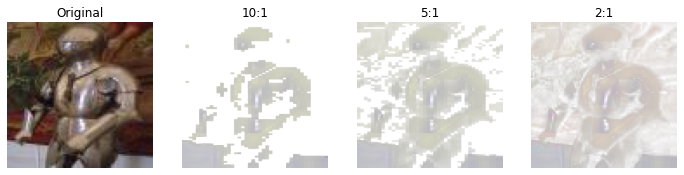

Predicted class for the original image: 618 with confidence: 0.2821


In [27]:
# 3. Select Random Image and Apply Compression
# Here, we load a random image and apply wavelet compression with different compression ratios (10:1, 5:1, 2:1).


# Select a random image from the dataset (for testing purposes)
random_img = random.choice(images)  # Assuming 'images' is a list of PIL images

# Resize the image to 84x84 pixels (as per your requirement)
img_resized = random_img.resize((84, 84))

# Convert the image to a numpy array for processing
img_np = np.array(img_resized)

# Apply wavelet compression with different compression ratios (10:1, 5:1, 2:1)
compressed_10 = compress_wavelet(img_np, keep_ratio=0.1)  # 10:1 compression
compressed_5 = compress_wavelet(img_np, keep_ratio=0.2)   # 5:1 compression
compressed_2 = compress_wavelet(img_np, keep_ratio=0.5)   # 2:1 compression



# 4. Visualize Original vs Compressed Images
# Next, we visualize the original and compressed images side by side:


# Visualize the original and compressed images (10:1, 5:1, 2:1)
plt.figure(figsize=(12, 4))
for i, image in enumerate([img_np, compressed_10, compressed_5, compressed_2]):
    plt.subplot(1, 4, i + 1)
    plt.imshow(image)
    plt.title(['Original', '10:1', '5:1', '2:1'][i])  # Title for each image
    plt.axis('off')  # Hide axis

plt.show()  # Display the images


# 5. Load Pretrained ResNet-18 Model
# We load the ResNet-18 model from PyTorch’s model zoo and adjust it for our dataset.

# Load the pretrained ResNet-18 model
model = models.resnet18(pretrained=True)
model.eval()  # Set the model to evaluation mode

# Define the image transformation pipeline (Resize, Normalize, Convert to tensor)
transform = transforms.Compose([
    # Step 1: Resize image slightly larger than target size for better augmentation flexibility
    transforms.Resize(112),  # Resize to 112x112 to enable random cropping to 96x96

    # Step 2: Apply spatial augmentations to increase data diversity
    transforms.RandomCrop(96),  # Random crop to target size (96x96)
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.RandomRotation(degrees=15),   # Slight random rotation within ±15 degrees
    transforms.RandomAffine(                  # Small random affine transformations
        degrees=0, 
        translate=(0.1, 0.1)                 # Translate up to 10% of image size
    ),

    # Step 3: Apply color-based augmentations to improve robustness to lighting
    transforms.ColorJitter(
        brightness=0.1,   # Small random brightness shift
        contrast=0.1,     # Small random contrast change
        saturation=0.1,   # Small saturation variation
        hue=0.05          # Slight hue shift
    ),

    # Step 4: Convert to tensor (required for PyTorch models)
    transforms.ToTensor(),

    # Step 5: Normalize with ImageNet statistics (helps with pretrained models)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),

    # Step 6: Optional regularization technique to simulate occlusions
    transforms.RandomErasing(
        p=0.2,             # Apply with 20% probability
        scale=(0.02, 0.2)  # Erased area between 2% and 20% of the image
    )
])


# 6 Perform Predictions on Original and Compressed Images
# Finally, we perform predictions on the original and compressed images to observe how compression affects model performance.


# Perform prediction on the original image
predicted_class, confidence = predict(img_np)
print(f"Predicted class for the original image: {predicted_class} with confidence: {confidence:.4f}")




## Evaluate Performance of Compression Levels 

In [28]:
# Model performance
labels = ['Original', '10:1', '5:1', '2:1']
images = [img_np, compressed_10, compressed_5, compressed_2]
for label, image in zip(labels, images):
    pred, conf = predict(image)
    print(f"{label} → Class: {pred}, Confidence: {conf:.4f}")

Original → Class: 63, Confidence: 0.3514
10:1 → Class: 937, Confidence: 0.5603
5:1 → Class: 666, Confidence: 0.0736
2:1 → Class: 926, Confidence: 0.5701


## 3.1 Create compressed versions of the training set using wavelet transform

In [30]:
import os
import numpy as np
import pywt
from PIL import Image
from tqdm import tqdm
from torchvision import transforms

def wavelet_compress_image_rgb(image_np, wavelet='db4', level=2, threshold_percent=90):
    """
    Apply wavelet-based compression to an RGB image.
    
    Parameters:
        image_np (ndarray): RGB image, values in [0,1]
        wavelet (str): Wavelet type (e.g., 'db4', 'haar')
        level (int): Decomposition level
        threshold_percent (float): Percentage of smallest coefficients to zero
    
    Returns:
        compressed_img (ndarray): Reconstructed RGB image after compression
    """
    compressed_channels = []
    
    # Apply wavelet compression to each channel (R, G, B)
    for i in range(3):
        channel = image_np[:, :, i]
        coeffs = pywt.wavedec2(channel, wavelet=wavelet, level=level)
        coeff_array, coeff_slices = pywt.coeffs_to_array(coeffs)
        
        total_coeffs = coeff_array.size
        sorted_idx = np.argsort(np.abs(coeff_array.flatten()))
        num_to_zero = int((threshold_percent / 100) * total_coeffs)
        
        coeff_array_flat = coeff_array.flatten()
        coeff_array_flat[sorted_idx[:num_to_zero]] = 0
        coeff_array_compressed = coeff_array_flat.reshape(coeff_array.shape)
        
        compressed_coeffs = pywt.array_to_coeffs(coeff_array_compressed, coeff_slices, output_format='wavedec2')
        reconstructed = pywt.waverec2(compressed_coeffs, wavelet=wavelet)
        
        compressed_channels.append(reconstructed)
    
    # Stack the compressed channels back together
    compressed_img = np.stack(compressed_channels, axis=-1)
    return np.clip(compressed_img, 0, 1)

# Set paths
original_train_dir = 'data/train'
compressed_train_dir = "data/train_db4_95_comp"
original_test_dir = 'data/test'
compressed_test_dir = "data/test_db4_95_comp"

os.makedirs(compressed_train_dir, exist_ok=True)

# Transform to normalize + convert to numpy
to_tensor = transforms.ToTensor()

# Apply compression class-by-class for test set
for cls in tqdm(os.listdir(original_test_dir)):
    class_path = os.path.join(original_test_dir, cls)
    save_path = os.path.join(compressed_test_dir, cls)
    os.makedirs(save_path, exist_ok=True)
    
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).convert("RGB").resize((84, 84))  # Open as RGB image
        img_np = np.array(img) / 255.0
        
        # Apply wavelet compression
        compressed_img = wavelet_compress_image_rgb(img_np, wavelet='db4', level=2, threshold_percent=90)
        
        # Save compressed image
        compressed_img_uint8 = (compressed_img * 255).astype(np.uint8)
        Image.fromarray(compressed_img_uint8).save(os.path.join(save_path, img_file))

# Apply compression class-by-class for train set
for cls in tqdm(os.listdir(original_train_dir)):
    class_path = os.path.join(original_train_dir, cls)
    save_path = os.path.join(compressed_train_dir, cls)
    os.makedirs(save_path, exist_ok=True)
    
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        img = Image.open(img_path).convert("RGB").resize((84, 84))  # Open as RGB image
        img_np = np.array(img) / 255.0
        
        # Apply wavelet compression
        compressed_img = wavelet_compress_image_rgb(img_np, wavelet='db4', level=2, threshold_percent=90)
        
        # Save compressed image
        compressed_img_uint8 = (compressed_img * 255).astype(np.uint8)
        Image.fromarray(compressed_img_uint8).save(os.path.join(save_path, img_file))


100%|██████████| 100/100 [03:56<00:00,  2.36s/it]


## lets show couple of pictures out of our compreseed data 

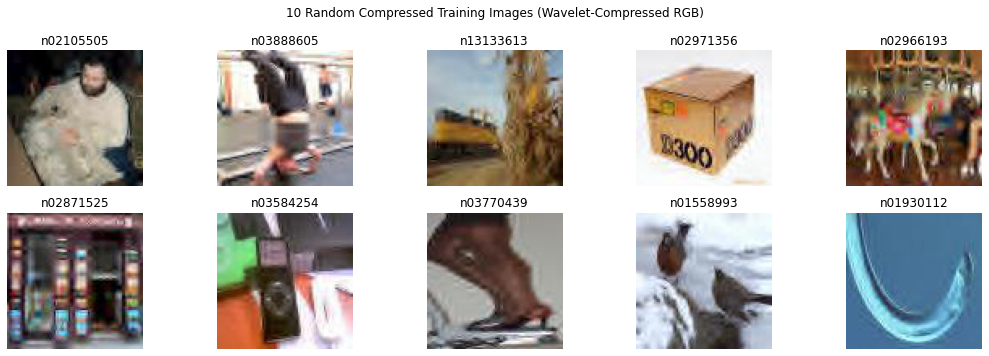

In [32]:
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

# Path to compressed training set (make sure this path is correct)
compressed_train_dir = "data/train_db4_95_comp"  # adjust according to your directory

# Step 1: Collect image paths from all class subfolders
image_paths = []
for cls in os.listdir(compressed_train_dir):
    cls_path = os.path.join(compressed_train_dir, cls)
    if os.path.isdir(cls_path):
        imgs = os.listdir(cls_path)
        for img in imgs:
            image_paths.append((cls, os.path.join(cls_path, img)))

# Step 2: Randomly sample 10 images
sampled_images = random.sample(image_paths, 10)

# Step 3: Plot the images
plt.figure(figsize=(15, 5))
for i, (cls, path) in enumerate(sampled_images):
    img = Image.open(path).convert("RGB")  # Load image as RGB
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)  # Display as RGB image
    plt.title(cls)
    plt.axis('off')

plt.suptitle("10 Random Compressed Training Images (Wavelet-Compressed RGB)")
plt.tight_layout()
plt.show()


## 3.2 Fine-tune model on the compressed training data

In [46]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm  # For the progress bar
import time  # For time tracking

# Path to your compressed training dataset
compressed_train_dir = "data/train_db4_95_comp" 

# Set up a transformation pipeline to resize and augment the data
transform = transforms.Compose([
    # Step 1: Resize image slightly larger than target size for better augmentation flexibility
    transforms.Resize(112),  # Resize to 112x112 to enable random cropping to 96x96

    # Step 2: Apply spatial augmentations to increase data diversity
    transforms.RandomCrop(96),  # Random crop to target size (96x96)
    transforms.RandomHorizontalFlip(p=0.5),  # Flip images horizontally with 50% probability
    transforms.RandomRotation(degrees=15),   # Slight random rotation within ±15 degrees
    transforms.RandomAffine(                  # Small random affine transformations
        degrees=0, 
        translate=(0.1, 0.1)                 # Translate up to 10% of image size
    ),

    # Step 3: Apply color-based augmentations to improve robustness to lighting
    transforms.ColorJitter(
        brightness=0.1,   # Small random brightness shift
        contrast=0.1,     # Small random contrast change
        saturation=0.1,   # Small saturation variation
        hue=0.05          # Slight hue shift
    ),

    # Step 4: Convert to tensor (required for PyTorch models)
    transforms.ToTensor(),

    # Step 5: Normalize with ImageNet statistics (helps with pretrained models)
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], 
        std=[0.229, 0.224, 0.225]
    ),

    # Step 6: Optional regularization technique to simulate occlusions
    transforms.RandomErasing(
        p=0.2,             # Apply with 20% probability
        scale=(0.02, 0.2)  # Erased area between 2% and 20% of the image
    )
])



# Create a dataset and dataloader for the compressed data
train_dataset = datasets.ImageFolder(root=compressed_train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# Validation loader (you should replace this with actual validation data if you have it)
val_loader = val_loader  # Using train_loader as placeholder for validation

# Device configuration (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Function to train the model with real-time progress bars
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    model.to(device)  # Move the model to GPU if available
    
    for epoch in range(num_epochs):
        print(f'\nEpoch {epoch+1}/{num_epochs}')
        
        # Track the start time of the epoch
        start_time = time.time()

        model.train()  # Set the model to training mode
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Training loop with progress bar
        with tqdm(train_loader, desc="Training", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)
                
                optimizer.zero_grad()  # Zero the gradients
                
                outputs = model(images)  # Forward pass
                loss = criterion(outputs, labels)  # Calculate loss
                loss.backward()  # Backward pass
                optimizer.step()  # Optimize parameters
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Update progress bar with the current loss and accuracy
                tepoch.set_postfix(loss=running_loss/len(tepoch), accuracy=100 * correct / total)
        
        # Time taken for the training loop
        end_time = time.time()
        train_time = end_time - start_time
        
        train_accuracy = 100 * correct / total
        print(f'Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%, Time: {train_time:.2f}s')

        # Evaluate on validation data
        model.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
        
        # Validation loop with progress bar
        with tqdm(val_loader, desc="Validation", unit="batch") as tepoch:
            with torch.no_grad():  # No need to compute gradients for validation
                for images, labels in tepoch:
                    images, labels = images.to(device), labels.to(device)
                    
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
                    
                    # Update progress bar with the current validation loss and accuracy
                    tepoch.set_postfix(loss=val_loss/len(tepoch), accuracy=100 * correct / total)
        
        val_accuracy = 100 * correct / total
        print(f'Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {val_accuracy:.2f}%')
    
    print("Training Complete!")

# Fine-tuning ResNet18 on compressed data
model_resnet = models.resnet18(pretrained=True)

model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 100)  # 100 classes in mini-imagenet
# Unfreeze all layers
for param in model_resnet.parameters():
    param.requires_grad = True

optimizer_resnet = optim.SGD(model_resnet.parameters(), lr=0.001, momentum=0.9, weight_decay=1e-4)

print("🔧 Fine-tuning ResNet18 on compressed data...")
train_model(model_resnet, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_resnet, num_epochs=1)

# # Fine-tuning MobileNetV2 on compressed data
# model_mobilenet = models.mobilenet_v2(pretrained=True)
# model_mobilenet.classifier[1] = nn.Linear(model_mobilenet.classifier[1].in_features, 100)
# optimizer_mobilenet = optim.SGD(model_mobilenet.classifier[1].parameters(), lr=0.01, momentum=0.9)

# print("🔧 Fine-tuning MobileNetV2 on compressed data...")
# train_model(model_mobilenet, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_mobilenet, num_epochs=5)


🔧 Fine-tuning ResNet18 on compressed data...

Epoch 1/1


Training: 100%|██████████| 1500/1500 [13:53<00:00,  1.80batch/s, accuracy=36.9, loss=2.62]  


Loss: 2.6235, Accuracy: 36.91%, Time: 833.35s


Validation: 100%|██████████| 1500/1500 [04:33<00:00,  5.48batch/s, accuracy=54.2, loss=1.74]   

Validation Loss: 1.7403, Accuracy: 54.24%
Training Complete!


In [47]:
torch.save(model_resnet.state_dict(), 'resnet18_finetuned_wavelet.pth')

## 3.3 Compare performance with models trained on uncompressed data

In [48]:
import torch
from torch import nn
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import os

# ───────────────────────────────────────────────
# Paths to datasets and model weights
# ───────────────────────────────────────────────
compressed_test_dir = "data/test_db4_95_comp"
uncompressed_test_dir = "data/test"

orig_model_path = "resnet_original_uncompressed_finetuned.pth"
wavelet_model_path = "resnet18_finetuned_wavelet.pth"

# ───────────────────────────────────────────────
# Define image transform (resize, normalize)
# ───────────────────────────────────────────────
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ───────────────────────────────────────────────
# Load datasets
# ───────────────────────────────────────────────
compressed_test_dataset = datasets.ImageFolder(root=compressed_test_dir, transform=transform)
uncompressed_test_dataset = datasets.ImageFolder(root=uncompressed_test_dir, transform=transform)

compressed_test_loader = DataLoader(compressed_test_dataset, batch_size=32, shuffle=False, num_workers=4)
uncompressed_test_loader = DataLoader(uncompressed_test_dataset, batch_size=32, shuffle=False, num_workers=4)

# ───────────────────────────────────────────────
# Define evaluation function
# ───────────────────────────────────────────────
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def evaluate_model(model, test_loader):
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    running_loss = 0.0
    criterion = nn.CrossEntropyLoss()

    with torch.no_grad():
        with tqdm(test_loader, desc="Evaluating", unit="batch") as tepoch:
            for images, labels in tepoch:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                running_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

                tepoch.set_postfix(loss=running_loss/len(tepoch), accuracy=100 * correct / total)

    accuracy = 100 * correct / total
    return accuracy, running_loss / len(test_loader)

# ───────────────────────────────────────────────
# Load both models
# ───────────────────────────────────────────────
def load_resnet(path):
    model = models.resnet18(pretrained=False)
    model.fc = nn.Linear(model.fc.in_features, 100)
    model.load_state_dict(torch.load(path, map_location=device))
    return model

print("🔄 Loading models...")
model_orig = load_resnet(orig_model_path)
model_wavelet = load_resnet(wavelet_model_path)

# ───────────────────────────────────────────────
# Evaluate both models on both test sets
# ───────────────────────────────────────────────
print("\n✅ Original model → Compressed test")
acc1, _ = evaluate_model(model_orig, compressed_test_loader)

print("\n✅ Wavelet model → Compressed test")
acc2, _ = evaluate_model(model_wavelet, compressed_test_loader)

print("\n✅ Original model → Uncompressed test")
acc3, _ = evaluate_model(model_orig, uncompressed_test_loader)

print("\n✅ Wavelet model → Uncompressed test")
acc4, _ = evaluate_model(model_wavelet, uncompressed_test_loader)

# ───────────────────────────────────────────────
# Final comparison summary
# ───────────────────────────────────────────────
print(f"""
📊 Accuracy Summary:

Uncompressed model → Compressed test:   {acc1:.2f}%
Compressed model  → Compressed test:   {acc2:.2f}%
Uncompressed model → Uncompressed test: {acc3:.2f}%
Compressed model  → Uncompressed test: {acc4:.2f}%
""")


🔄 Loading models...

✅ Original model → Compressed test


Evaluating: 100%|██████████| 188/188 [00:45<00:00,  4.18batch/s, accuracy=57.7, loss=1.64] 



✅ Wavelet model → Compressed test


Evaluating: 100%|██████████| 188/188 [00:39<00:00,  4.71batch/s, accuracy=56.6, loss=1.66] 



✅ Original model → Uncompressed test


Evaluating: 100%|██████████| 188/188 [00:40<00:00,  4.62batch/s, accuracy=66.2, loss=1.28] 



✅ Wavelet model → Uncompressed test


Evaluating: 100%|██████████| 188/188 [00:42<00:00,  4.45batch/s, accuracy=57.3, loss=1.64] 


📊 Accuracy Summary:

Uncompressed model → Compressed test:   57.67%
Compressed model  → Compressed test:   56.60%
Uncompressed model → Uncompressed test: 66.15%
Compressed model  → Uncompressed test: 57.27%



## 3.4 Analyze how training on compressed data affects robustness


In [ ]:
# comment based on the above results

## 3.5 Determine optimal compression level for training

In [ ]:
# compare between:  

# High compression ( 10:1 ratio)
# Medium compression ( 5:1 ratio)
# Low compression ( 2:1 ratio)

## 3.6 Evaluate if models fine-tuned on compressed data generalize better to compressed test images


In [ ]:
# comment based on the above results

## 4. Compressed Sensing Experiment


## 4.1 Select 20 diverse test images from different classes


## 4.2  Implement compressed sensing acquisition and reconstruction:

### Create random measurement matrices
### Simulate CS measurements at different sampling rates 0.25, 0.5 and 0.75
### Implement a suitable reconstruction algorithms (e.g., L1-minimization)

# Next, the sampling rate = 0.25

In [4]:
import numpy as np
import cvxpy as cp
from sklearn.linear_model import Lasso
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.fftpack import dct, idct

# Define the DCT transformation functions
def apply_dct(img):
    """
    Apply Discrete Cosine Transform (DCT) to the image.
    """
    img_dct = dct(dct(img, axis=0, norm='ortho'), axis=1, norm='ortho')
    return img_dct

def apply_idct(dct_img):
    """
    Apply Inverse Discrete Cosine Transform (IDCT) to get the reconstructed image.
    """
    img_idct = idct(idct(dct_img, axis=1, norm='ortho'), axis=0, norm='ortho')
    return img_idct

# Define the CS reconstruction function
def compressive_sensing_reconstruct(img, sampling_rate):
    h, w = img.shape
    n = h * w  # Total number of pixels in the image (1024 for 32x32)
    m = int(sampling_rate * n)  # Number of measurements based on sampling rate
    
    # Apply DCT to the image (preprocessing)
    img_dct = apply_dct(img)

    # Flatten the DCT-transformed image
    x_true = img_dct.flatten()  
    A = np.random.randn(m, n) / np.sqrt(m)  # Gaussian random measurement matrix
    y = A @ x_true  # Compressed measurements
    
    # L1 Minimization (Lasso) for reconstruction
    x_hat = cp.Variable(n)
    objective = cp.Minimize(cp.norm(x_hat, 1))  # Minimize L1 norm
    constraints = [A @ x_hat == y]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)

    x_recon = x_hat.value
    img_recon_dct = np.reshape(x_recon, (h, w))  # Reshape to 2D

    # Apply Inverse DCT (IDCT) to get the image back to the spatial domain
    img_recon = apply_idct(img_recon_dct)

    return img_recon, psnr(img, img_recon, data_range=1.0), ssim(img, img_recon, data_range=1.0)

# Function to simulate CS and perform reconstruction at different sampling rates
def simulate_cs_reconstruction(selected_images, sampling_rates=[0.25]):
    results = []

    # Loop through each sampling rate
    for rate in sampling_rates:
        print(f"\n🔍 Processing sampling rate: {rate}")
        
        # Loop through each selected image
        for cls, img_path in selected_images:
            img = Image.open(img_path).convert('L').resize((32, 32))  # Resize to 32x32 and convert to grayscale
            img_np = np.array(img) / 255.0  # Normalize to [0, 1]
            
            # Perform compressed sensing reconstruction
            recon_img, psnr_val, ssim_val = compressive_sensing_reconstruct(img_np, rate)
            
            results.append({
                "class": cls,
                "sampling_rate": rate,
                "psnr": round(psnr_val, 2),
                "ssim": round(ssim_val, 3),
                "image_path": img_path,
                "reconstructed_image": recon_img  # Save the reconstructed image itself
            })
    
    return results

# === Step 1: Select 3 diverse test images from different classes ===
selected_images = []
all_classes = sorted(os.listdir('data/test'))
selected_classes = random.sample(all_classes, 20)

# For each selected class, choose one random image
for cls in selected_classes:
    class_path = os.path.join('data/test', cls)
    images = os.listdir(class_path)
    image_file = random.choice(images)
    selected_images.append((cls, os.path.join(class_path, image_file)))

# === Step 2: Apply CS reconstruction to all selected images at 3 sampling rates ===
results = simulate_cs_reconstruction(selected_images)

# === Step 3: Store results in a DataFrame for easy analysis ===
import pandas as pd
df = pd.DataFrame(results)
print(df.head())  # Display first few results

df.to_pickle("reconstructed_df.pkl")



C:\Users\hassa\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,



🔍 Processing sampling rate: 0.25
       class  sampling_rate   psnr   ssim  \
0  n03888605           0.25  20.60  0.656   
1  n04596742           0.25  19.44  0.693   
2  n03998194           0.25  26.04  0.694   
3  n02606052           0.25  20.59  0.532   
4  n03838899           0.25  15.10  0.553   

                                  image_path  \
0  data/test\n03888605\n0388860500000876.jpg   
1  data/test\n04596742\n0459674200000655.jpg   
2  data/test\n03998194\n0399819400000853.jpg   
3  data/test\n02606052\n0260605200000555.jpg   
4  data/test\n03838899\n0383889900000754.jpg   

                                 reconstructed_image  
0  [[0.5280971321628275, 0.5926834428521905, 0.50...  
1  [[0.46125677597895043, 0.5133635885180019, 0.6...  
2  [[0.3759574164527194, 0.3956410149380132, 0.46...  
3  [[0.21911323700273683, 0.2897754725088463, 0.3...  
4  [[1.2006122566927742, 0.8899909897209605, 0.99...  


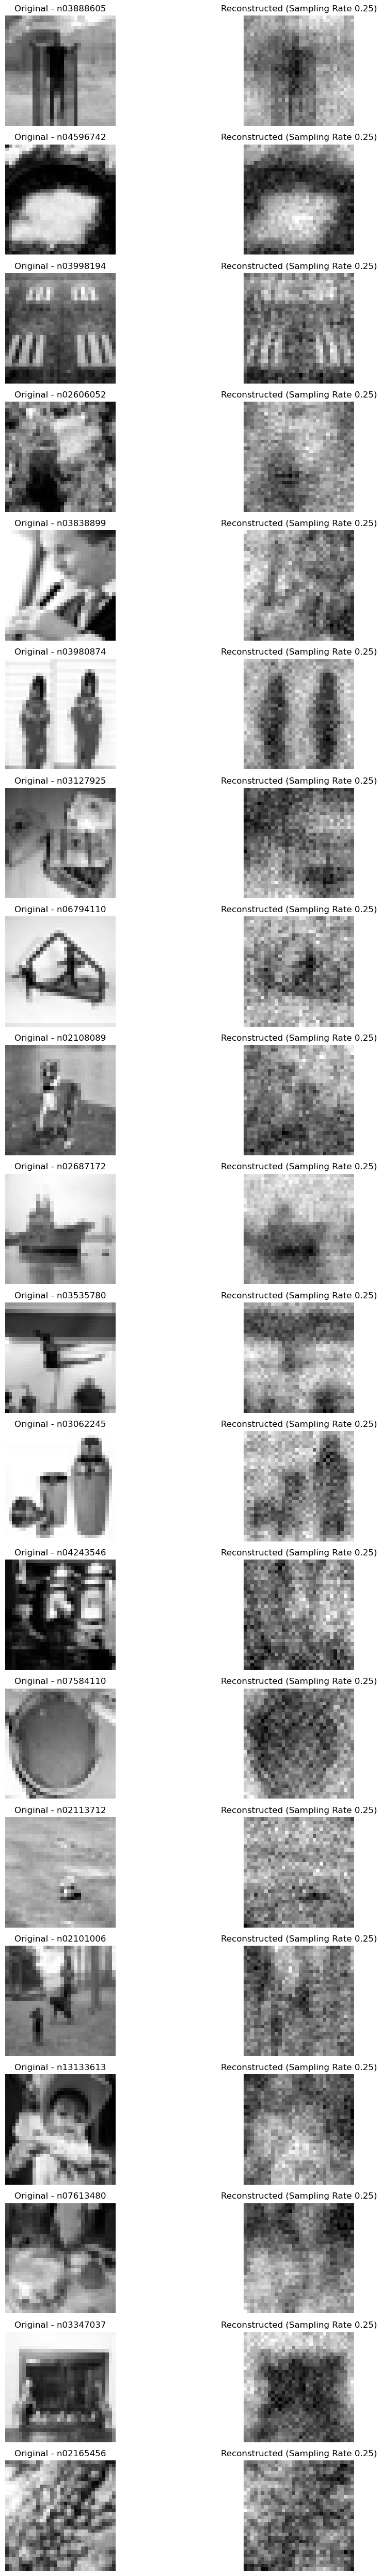

In [5]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# === Step 4: Plot original vs reconstructed images ===
sampling_rate_to_plot = 0.25  # Example: Plot reconstructed images at sampling_rate = 0.25
filtered_results = [r for r in results if r['sampling_rate'] == sampling_rate_to_plot]

# Update subplot dimensions for 40 images
plt.figure(figsize=(12, 50))  # Adjust the size based on the number of images (increase height)

# Loop through the filtered results and plot the images
for i, entry in enumerate(filtered_results):
    cls = entry['class']
    orig_path = entry['image_path']
    recon_img = entry['reconstructed_image']  # Reconstructed image from CS
    
    # Load original image
    orig_img = Image.open(orig_path).convert('L').resize((32, 32))
    orig_np = np.array(orig_img) / 255.0  # Normalize original image
    
    # Plot original image
    plt.subplot(20, 2, 2*i + 1)  # 20 rows, 2 columns, adjust index for each image
    plt.imshow(orig_np, cmap='gray')
    plt.title(f"Original - {cls}")
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(20, 2, 2*i + 2)  # 20 rows, 2 columns, adjust index for each image
    plt.imshow(recon_img, cmap='gray')
    plt.title(f"Reconstructed (Sampling Rate {sampling_rate_to_plot})")
    plt.axis('off')

# Adjust layout to ensure there's no overlap
plt.tight_layout()
plt.show()


 ## 4.3  Compare reconstruction quality across sampling rates

# Next, the sampling rate = 0.5

In [8]:
import numpy as np
import cvxpy as cp
from sklearn.linear_model import Lasso
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
from scipy.fftpack import dct, idct

# Define the DCT transformation functions
def apply_dct(img):
    """
    Apply Discrete Cosine Transform (DCT) to the image.
    """
    img_dct = dct(dct(img, axis=0, norm='ortho'), axis=1, norm='ortho')
    return img_dct

def apply_idct(dct_img):
    """
    Apply Inverse Discrete Cosine Transform (IDCT) to get the reconstructed image.
    """
    img_idct = idct(idct(dct_img, axis=1, norm='ortho'), axis=0, norm='ortho')
    return img_idct

# Define the CS reconstruction function
def compressive_sensing_reconstruct(img, sampling_rate):
    h, w = img.shape
    n = h * w  # Total number of pixels in the image (1024 for 32x32)
    m = int(sampling_rate * n)  # Number of measurements based on sampling rate
    
    # Apply DCT to the image (preprocessing)
    img_dct = apply_dct(img)

    # Flatten the DCT-transformed image
    x_true = img_dct.flatten()  
    A = np.random.randn(m, n) / np.sqrt(m)  # Gaussian random measurement matrix
    y = A @ x_true  # Compressed measurements
    
    # L1 Minimization (Lasso) for reconstruction
    x_hat = cp.Variable(n)
    objective = cp.Minimize(cp.norm(x_hat, 1))  # Minimize L1 norm
    constraints = [A @ x_hat == y]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver=cp.SCS, verbose=False)

    x_recon = x_hat.value
    img_recon_dct = np.reshape(x_recon, (h, w))  # Reshape to 2D

    # Apply Inverse DCT (IDCT) to get the image back to the spatial domain
    img_recon = apply_idct(img_recon_dct)

    return img_recon, psnr(img, img_recon, data_range=1.0), ssim(img, img_recon, data_range=1.0)

# Function to simulate CS and perform reconstruction at different sampling rates
def simulate_cs_reconstruction(selected_images, sampling_rates=[0.5]):
    results = []

    # Loop through each sampling rate
    for rate in sampling_rates:
        print(f"\n🔍 Processing sampling rate: {rate}")
        
        # Loop through each selected image
        for cls, img_path in selected_images:
            img = Image.open(img_path).convert('L').resize((32, 32))  # Resize to 32x32 and convert to grayscale
            img_np = np.array(img) / 255.0  # Normalize to [0, 1]
            
            # Perform compressed sensing reconstruction
            recon_img, psnr_val, ssim_val = compressive_sensing_reconstruct(img_np, rate)
            
            results.append({
                "class": cls,
                "sampling_rate": rate,
                "psnr": round(psnr_val, 2),
                "ssim": round(ssim_val, 3),
                "image_path": img_path,
                "reconstructed_image": recon_img  # Save the reconstructed image itself
            })
    
    return results

# === Step 1: Select 3 diverse test images from different classes ===
selected_images = []
all_classes = sorted(os.listdir('data/test'))
selected_classes = random.sample(all_classes, 20)

# For each selected class, choose one random image
for cls in selected_classes:
    class_path = os.path.join('data/test', cls)
    images = os.listdir(class_path)
    image_file = random.choice(images)
    selected_images.append((cls, os.path.join(class_path, image_file)))

# === Step 2: Apply CS reconstruction to all selected images at 3 sampling rates ===
results = simulate_cs_reconstruction(selected_images)

# === Step 3: Store results in a DataFrame for easy analysis ===
import pandas as pd
df = pd.DataFrame(results)
print(df.head())  # Display first few results

df.to_pickle("reconstructed_df.pkl")




🔍 Processing sampling rate: 0.5
       class  sampling_rate   psnr   ssim  \
0  n03908618            0.5  22.40  0.725   
1  n07697537            0.5  22.71  0.794   
2  n02443484            0.5  21.93  0.749   
3  n04443257            0.5  26.25  0.744   
4  n03347037            0.5  25.05  0.859   

                                  image_path  \
0  data/test\n03908618\n0390861800000712.jpg   
1  data/test\n07697537\n0769753700000732.jpg   
2  data/test\n02443484\n0244348400000107.jpg   
3  data/test\n04443257\n0444325700000179.jpg   
4  data/test\n03347037\n0334703700000840.jpg   

                                 reconstructed_image  
0  [[0.40018130397434204, 0.46728586584950405, 0....  
1  [[0.3197738348133353, 0.21402661724947947, 0.2...  
2  [[0.24757403182272017, 0.2611042104758744, 0.2...  
3  [[0.30152911030120555, 0.31922962284306183, 0....  
4  [[0.9523152185480932, 0.9879714220882887, 0.95...  


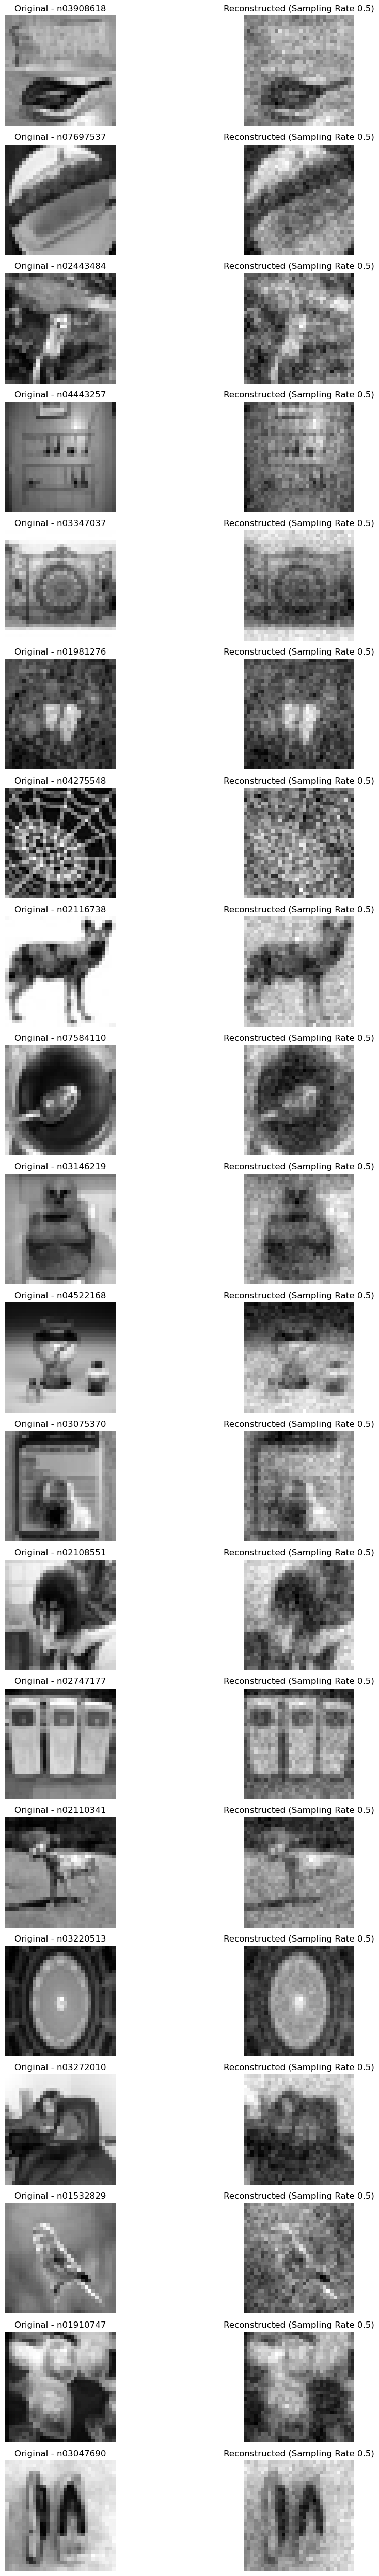

In [9]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

# === Step 4: Plot original vs reconstructed images ===
sampling_rate_to_plot = 0.5  # Example: Plot reconstructed images at sampling_rate = 0.25
filtered_results = [r for r in results if r['sampling_rate'] == sampling_rate_to_plot]

# Update subplot dimensions for 40 images
plt.figure(figsize=(12, 50))  # Adjust the size based on the number of images (increase height)

# Loop through the filtered results and plot the images
for i, entry in enumerate(filtered_results):
    cls = entry['class']
    orig_path = entry['image_path']
    recon_img = entry['reconstructed_image']  # Reconstructed image from CS
    
    # Load original image
    orig_img = Image.open(orig_path).convert('L').resize((32, 32))
    orig_np = np.array(orig_img) / 255.0  # Normalize original image
    
    # Plot original image
    plt.subplot(20, 2, 2*i + 1)  # 20 rows, 2 columns, adjust index for each image
    plt.imshow(orig_np, cmap='gray')
    plt.title(f"Original - {cls}")
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(20, 2, 2*i + 2)  # 20 rows, 2 columns, adjust index for each image
    plt.imshow(recon_img, cmap='gray')
    plt.title(f"Reconstructed (Sampling Rate {sampling_rate_to_plot})")
    plt.axis('off')

# Adjust layout to ensure there's no overlap
plt.tight_layout()
plt.show()


# Next, the sampling rate = 0.75

In [15]:
import numpy as np
import cvxpy as cp
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import random
import matplotlib.pyplot as plt
from PIL import Image
import os
import pandas as pd
import pywt

# ───────────────────────────────────────────────
# 1. Wavelet Transform Utilities (Haar)
# ───────────────────────────────────────────────
def apply_wavelet(img):
    return pywt.dwt2(img, 'haar')

def apply_inverse_wavelet(coeffs):
    return pywt.idwt2(coeffs, 'haar')

# ───────────────────────────────────────────────
# 2. RGB CS Reconstruction Function
# ───────────────────────────────────────────────
def compressive_sensing_reconstruct_rgb(img_rgb, sampling_rate):
    h, w, _ = img_rgb.shape
    recon_rgb = np.zeros_like(img_rgb)

    for c in range(3):  # R, G, B channels
        img = img_rgb[..., c]
        LL, (LH, HL, HH) = apply_wavelet(img)

        x_true = np.concatenate([
            LL.flatten(), LH.flatten(), HL.flatten(), HH.flatten()
        ])
        n = x_true.size
        m = int(sampling_rate * n)

        A = np.random.randn(m, n) / np.sqrt(m)
        y = A @ x_true

        x_hat = cp.Variable(n)
        objective = cp.Minimize(cp.norm(x_hat, 1))
        constraints = [A @ x_hat == y]
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.SCS, verbose=False)

        # Reconstruct wavelet bands
        split1 = LL.size
        split2 = split1 + LH.size
        split3 = split2 + HL.size

        LLr = x_hat.value[:split1].reshape(LL.shape)
        LHr = x_hat.value[split1:split2].reshape(LH.shape)
        HLr = x_hat.value[split2:split3].reshape(HL.shape)
        HHr = x_hat.value[split3:].reshape(HH.shape)

        coeffs_recon = (LLr, (LHr, HLr, HHr))
        recon_channel = apply_inverse_wavelet(coeffs_recon)
        recon_rgb[..., c] = np.clip(recon_channel, 0, 1)

    return recon_rgb

# ───────────────────────────────────────────────
# 3. Simulate CS on Selected Images (RGB)
# ───────────────────────────────────────────────
def simulate_cs_reconstruction(selected_images, sampling_rates=[0.75]):
    results = []

    for rate in sampling_rates:
        print(f"\n🔍 Processing sampling rate: {rate}")
        for cls, img_path in selected_images:
            img = Image.open(img_path).convert('RGB').resize((32, 32))
            img_np = np.array(img) / 255.0  # Shape: (32, 32, 3)

            recon_img = compressive_sensing_reconstruct_rgb(img_np, rate)

            # For PSNR/SSIM: compare grayscale versions
            gray_orig = np.mean(img_np, axis=2)
            gray_recon = np.mean(recon_img, axis=2)
            psnr_val = psnr(gray_orig, gray_recon, data_range=1.0)
            ssim_val = ssim(gray_orig, gray_recon, data_range=1.0)

            results.append({
                "class": cls,
                "sampling_rate": rate,
                "psnr": round(psnr_val, 2),
                "ssim": round(ssim_val, 3),
                "image_path": img_path,
                "reconstructed_image": recon_img  # full RGB image
            })

    return results

# ───────────────────────────────────────────────
# 4. Select 20 Diverse Test Images
# ───────────────────────────────────────────────
selected_images = []
all_classes = sorted(os.listdir('data/test'))
selected_classes = random.sample(all_classes, 20)

for cls in selected_classes:
    class_path = os.path.join('data/test', cls)
    images = os.listdir(class_path)
    image_file = random.choice(images)
    selected_images.append((cls, os.path.join(class_path, image_file)))

# ───────────────────────────────────────────────
# 5. Run Reconstruction and Save Results
# ───────────────────────────────────────────────
results = simulate_cs_reconstruction(selected_images)

df = pd.DataFrame(results)
df.to_pickle("reconstructed_df.pkl")
print(" Saved DataFrame with RGB CS-reconstructed images: reconstructed_df.pkl")
print(df.head())



🔍 Processing sampling rate: 0.75
 Saved DataFrame with RGB CS-reconstructed images: reconstructed_df.pkl
       class  sampling_rate   psnr   ssim  \
0  n03980874           0.75  30.54  0.959   
1  n02110063           0.75  25.94  0.968   
2  n01558993           0.75  24.11  0.906   
3  n03075370           0.75  23.01  0.926   
4  n03062245           0.75  28.43  0.943   

                                  image_path  \
0  data/test\n03980874\n0398087400001168.jpg   
1  data/test\n02110063\n0211006300000551.jpg   
2  data/test\n01558993\n0155899300000897.jpg   
3  data/test\n03075370\n0307537000000366.jpg   
4  data/test\n03062245\n0306224500001052.jpg   

                                 reconstructed_image  
0  [[[0.0, 0.02088074981618836, 0.015438116891802...  
1  [[[0.6756051081075714, 0.6484302854470387, 0.7...  
2  [[[0.19574090999227248, 0.270660973011035, 0.2...  
3  [[[0.8222138357620501, 0.9138985571054984, 1.0...  
4  [[[0.36504667717892614, 0.3273402423309115, 0....  


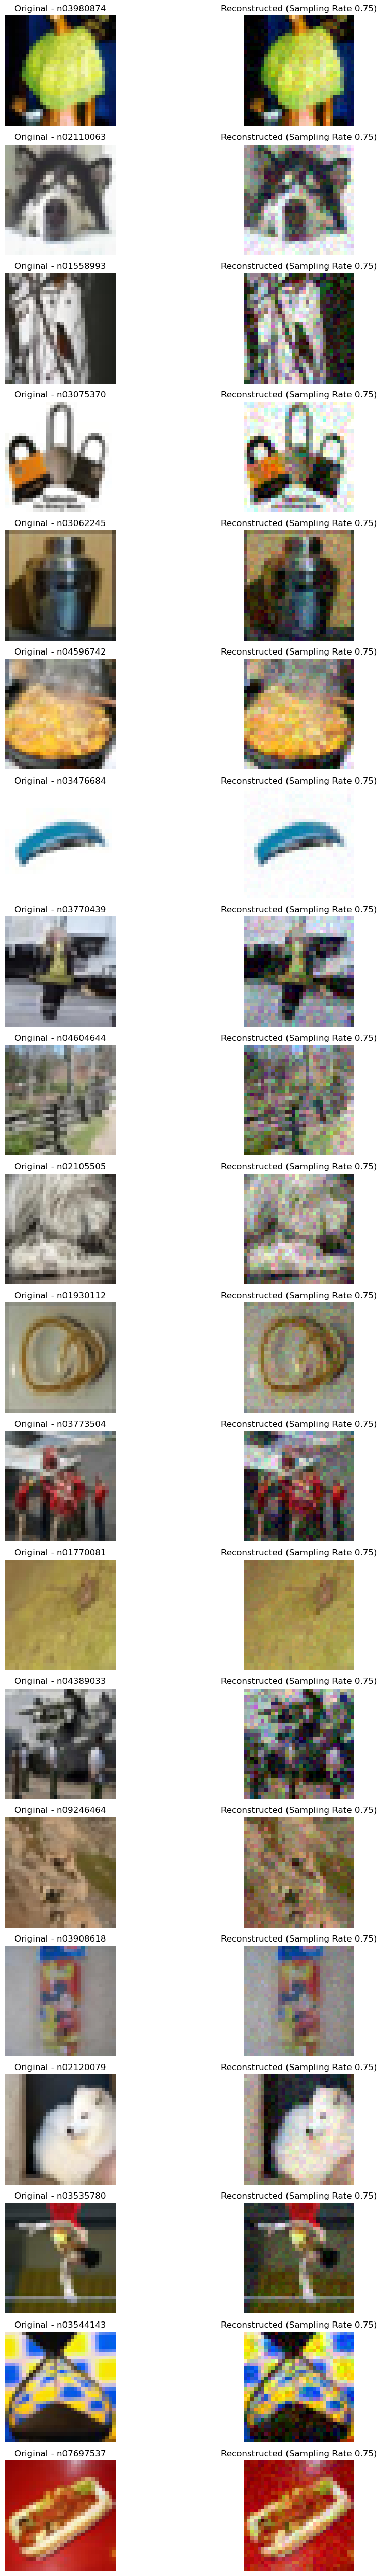

In [16]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

sampling_rate_to_plot = 0.75
filtered_results = [r for r in results if r['sampling_rate'] == sampling_rate_to_plot]

rows = len(filtered_results)
plt.figure(figsize=(12, rows * 2.5))

for i, entry in enumerate(filtered_results):
    cls = entry['class']
    orig_path = entry['image_path']
    recon_img = entry['reconstructed_image']  # RGB image

    # Load original RGB image
    orig_img = Image.open(orig_path).convert('RGB').resize((32, 32))
    orig_np = np.array(orig_img) / 255.0  # RGB in [0, 1]

    # Plot original image
    plt.subplot(rows, 2, 2*i + 1)
    plt.imshow(orig_np)
    plt.title(f"Original - {cls}")
    plt.axis('off')

    # Plot reconstructed image
    plt.subplot(rows, 2, 2*i + 2)
    plt.imshow(recon_img)
    plt.title(f"Reconstructed (Sampling Rate {sampling_rate_to_plot})")
    plt.axis('off')

plt.tight_layout()
plt.show()


# Test reconstructed images on both model versions:
### Models fine-tuned on original data
### Models fine-tuned on compressed data

# Test on Model fine-tuned on uncompressed data

In [21]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np

# ───────────── Step 1: Load CS-reconstructed RGB images ─────────────
df = pd.read_pickle("reconstructed_df.pkl")  # contains 'reconstructed_image' and 'class'

# ───────────── Step 2: Rebuild class-to-index mapping from train dir ─────────────
train_dir = 'data/train'  # directory used during original training
import os
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(os.listdir(train_dir)))}

# ───────────── Step 3: Define preprocessing ─────────────
transform = transforms.Compose([
    transforms.Resize((96, 96)),  # match model input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet stats
                         std=[0.229, 0.224, 0.225]),
])

# ───────────── Step 4: Convert images to tensors ─────────────
tensor_list = []
label_list = []

for _, row in df.iterrows():
    class_name = row['class']
    if class_name not in class_to_idx:
        continue  # skip unknown classes

    img_rgb = row['reconstructed_image']  # shape: (32, 32, 3) in [0, 1]
    img_uint8 = (img_rgb * 255).clip(0, 255).astype('uint8')
    pil_rgb = Image.fromarray(img_uint8, mode='RGB')

    tensor = transform(pil_rgb)
    tensor_list.append(tensor)
    label_list.append(class_to_idx[class_name])

# ───────────── Step 5: Dataset and DataLoader ─────────────
class CachedDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.images[idx], self.labels[idx]

imgs_tensor = torch.stack(tensor_list)
labels_tensor = torch.tensor(label_list)

loader = DataLoader(CachedDataset(imgs_tensor, labels_tensor), batch_size=32, shuffle=False)

# ───────────── Step 6: Load fine-tuned model (on original data) ─────────────
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 100)  # mini-ImageNet has 100 classes
model.load_state_dict(torch.load('resnet_original_uncompressed_finetuned.pth', map_location=device))
model.to(device).eval()

# ───────────── Step 7: Evaluate ─────────────
correct = total = 0
with torch.no_grad():
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = 100 * correct / total
print(f"\n Accuracy on CS-reconstructed RGB images (original-trained model): {accuracy:.2f}%")


C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



 Accuracy on CS-reconstructed RGB images (original-trained model): 30.00%


# Test on Model fine-tuned on compressed data

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from PIL import Image
import pandas as pd
import numpy as np
import os

# Step 1: Load reconstructed RGB images from pickle
df = pd.read_pickle("reconstructed_df.pkl")

# Step 2: Rebuild class-to-index mapping from the training directory used during wavelet training
train_dir = 'data/train_db4_95_comp'
class_to_idx = {cls: idx for idx, cls in enumerate(sorted(os.listdir(train_dir)))}

# Step 3: Define the same transform used during training
transform = transforms.Compose([
    transforms.Resize((96, 96)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225]),
])

# Step 4: Convert each image to tensor
tensor_list = []
label_list = []

for _, row in df.iterrows():
    class_name = row['class']
    if class_name not in class_to_idx:
        continue  # skip unknown classes

    img_rgb = row['reconstructed_image']
    img_uint8 = (img_rgb * 255).clip(0, 255).astype('uint8')
    pil_rgb = Image.fromarray(img_uint8, mode='RGB')
    tensor = transform(pil_rgb)

    tensor_list.append(tensor)
    label_list.append(class_to_idx[class_name])

# Step 5: Build DataLoader
class CachedDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
    def __len__(self): return len(self.labels)
    def __getitem__(self, idx): return self.images[idx], self.labels[idx]

imgs_tensor = torch.stack(tensor_list)
labels_tensor = torch.tensor(label_list)
loader = DataLoader(CachedDataset(imgs_tensor, labels_tensor), batch_size=32, shuffle=False)

# Step 6: Load the wavelet-trained ResNet model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = models.resnet18(pretrained=False)
model.fc = nn.Linear(model.fc.in_features, 100)
model.load_state_dict(torch.load('resnet18_finetuned_wavelet.pth', map_location=device))
model.to(device).eval()

# Step 7: Evaluate
correct = total = 0
with torch.no_grad():
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        preds = model(X).argmax(dim=1)
        correct += (preds == y).sum().item()
        total += y.size(0)

accuracy = 100 * correct / total
print(f"\n Accuracy on CS-reconstructed RGB images (wavelet-trained model): {accuracy:.2f}%")


C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\hassa\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)



 Accuracy on CS-reconstructed RGB images (wavelet-trained model): 50.00%


# Analyze performance differences and determine which approach is more robust

In [ ]:
# comment based on the above results